# WHY FAKE NEWS IS A PROBLEM?
**Fake news refers to misinformation, disinformation or mal-information which is spread through word of mouth and traditional media and more recently through digital forms of communication such as edited videos, memes, unverified advertisements and social media propagated rumours.Fake news spread through social media has become a serious problem, with the potential of it resulting in mob violence, suicides etc as a result of misinformation circulated on social media.**
![image.png](attachment:image.png)

# BRIEF DESCRIPTION OF DATASET
**This dataset consists of about 40000 articles consisting of fake as well as real news. Our aim is train our model so that it can correctly predict whether a given piece of news is real or fake.The fake and real news data is given in two separate datasets with each dataset consisting around 20000 articles each.**

In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# LOADING THE NECESSARY LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [3]:
import pandas as pd
import io
from google.colab import files

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# IMPORTING THE DATASET

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rakibulshezan","key":"d6956859467d11693eb8f842bd380125"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json


In [7]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

100% 41.0M/41.0M [00:00<00:00, 22.8MB/s]



In [8]:
from zipfile import ZipFile
file_name = 'fake-and-real-news-dataset.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [17]:
fake = pd.read_csv('/content/Fake.csv')
true = pd.read_csv('/content/True.csv')

In [18]:
# The following is a crude way to remove the @realDonaldTrump tweet disclaimer and State/Publisher at start of text

cleansed_data = []
for data in true.text:
    if "@realDonaldTrump : - " in data:
        cleansed_data.append(data.split("@realDonaldTrump : - ")[1])
    elif "(Reuters) -" in data:
        cleansed_data.append(data.split("(Reuters) - ")[1])
    else:
        cleansed_data.append(data)

true["text"] = cleansed_data
true.head(10)

title  ...                date
0  As U.S. budget fight looms, Republicans flip t...  ...  December 31, 2017 
1  U.S. military to accept transgender recruits o...  ...  December 29, 2017 
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  December 31, 2017 
3  FBI Russia probe helped by Australian diplomat...  ...  December 30, 2017 
4  Trump wants Postal Service to charge 'much mor...  ...  December 29, 2017 
5  White House, Congress prepare for talks on spe...  ...  December 29, 2017 
6  Trump says Russia probe will be fair, but time...  ...  December 29, 2017 
7  Factbox: Trump on Twitter (Dec 29) - Approval ...  ...  December 29, 2017 
8         Trump on Twitter (Dec 28) - Global Warming  ...  December 29, 2017 
9  Alabama official to certify Senator-elect Jone...  ...  December 28, 2017 

[10 rows x 4 columns]

# DATA VISUALIZATION AND PREPROCESSING

In [19]:
true.head()

title  ...                date
0  As U.S. budget fight looms, Republicans flip t...  ...  December 31, 2017 
1  U.S. military to accept transgender recruits o...  ...  December 29, 2017 
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  December 31, 2017 
3  FBI Russia probe helped by Australian diplomat...  ...  December 30, 2017 
4  Trump wants Postal Service to charge 'much mor...  ...  December 29, 2017 

[5 rows x 4 columns]

In [21]:
# Merging title and text
fake['Sentences'] = fake['title'] + ' ' + fake['text']
true['Sentences'] = true['title'] + ' ' + true['text']

# Adding fake and true label
fake['Label'] = 0
true['Label'] = 1

# We can merge both together since we now have labels
df = pd.concat([fake, true])

# Randomize the rows so its all mixed up
df = df.sample(frac=1).reset_index(drop=True)

# Drop columns not needed
df = df.drop(['title', 'text', 'subject', 'date'], axis = 1)

df.head(10)

Sentences  Label
0   Kellyanne Conway: Meryl Streep Incited ‘Peopl...      0
1  Virginia Senate approves electric chair amid d...      1
2  WOW! COMPANY THAT BUYS ABORTED BABY PARTS FROM...      0
3   If Your Trump-Supporting Family Tries To Talk...      0
4   WATCH: Film About Barack And Michelle Set To ...      0
5  Gunman attacks Saudi security forces at gate o...      1
6  Exclusive: Trump says U.S. wants fair treatmen...      1
7  South Korea, China agree to manage North Korea...      1
8  ART CONTEST WINNER Disqualified for Being a Tr...      0
9   Donald Trump Storms Glenn Beck’s Ted Cruz Ral...      0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


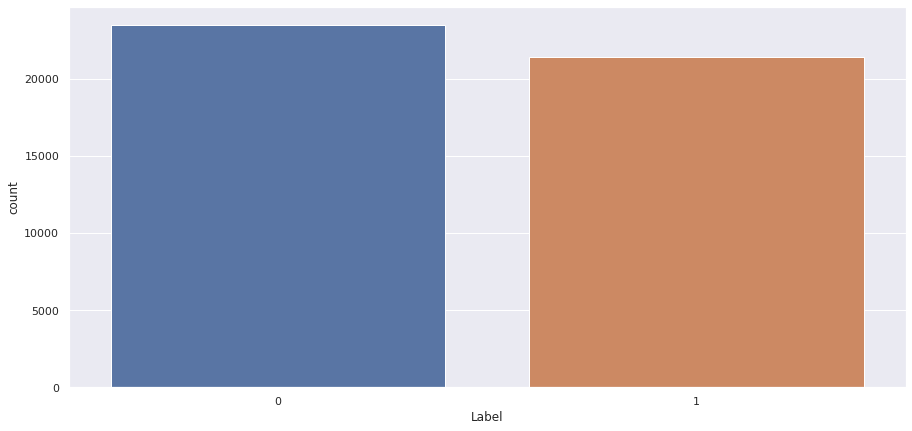

In [27]:
plt.figure(figsize=(15,7))
sns.set(style="darkgrid")
sns.countplot(df['Label'])

**SO, WE CAN SEE THAT THE DATASET IS BALANCED**

In [28]:
df.head()

Sentences  Label
0   Kellyanne Conway: Meryl Streep Incited ‘Peopl...      0
1  Virginia Senate approves electric chair amid d...      1
2  WOW! COMPANY THAT BUYS ABORTED BABY PARTS FROM...      0
3   If Your Trump-Supporting Family Tries To Talk...      0
4   WATCH: Film About Barack And Michelle Set To ...      0

In [29]:
df.isna().sum() # Checking for nan Values

Sentences    0
Label        0
dtype: int64

In [ ]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "speaker", hue = "label-liar" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

**WHAT ARE STOPWORDS?**

**Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.**

In [31]:
import nltk
nltk.download('stopwords')
  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [32]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

**DATA CLEANING**

In [34]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
def rem_punctuation(text):
  return text.translate(str.maketrans('','',string.punctuation))
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = rem_punctuation(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['Sentences']=df['Sentences'].apply(denoise_text)

In [35]:
df.head()

Sentences  Label
0  Kellyanne Conway Meryl Streep Incited ‘People’...      0
1  Virginia Senate approves electric chair amid d...      1
2  WOW COMPANY BUYS ABORTED BABY PARTS PLANNED PA...      0
3  TrumpSupporting Family Tries Talk Politics Tod...      0
4  WATCH Film Barack Michelle Set Debut Plot Amaz...      0

**WORDCLOUD FOR REAL TEXT (LABEL - 1)**

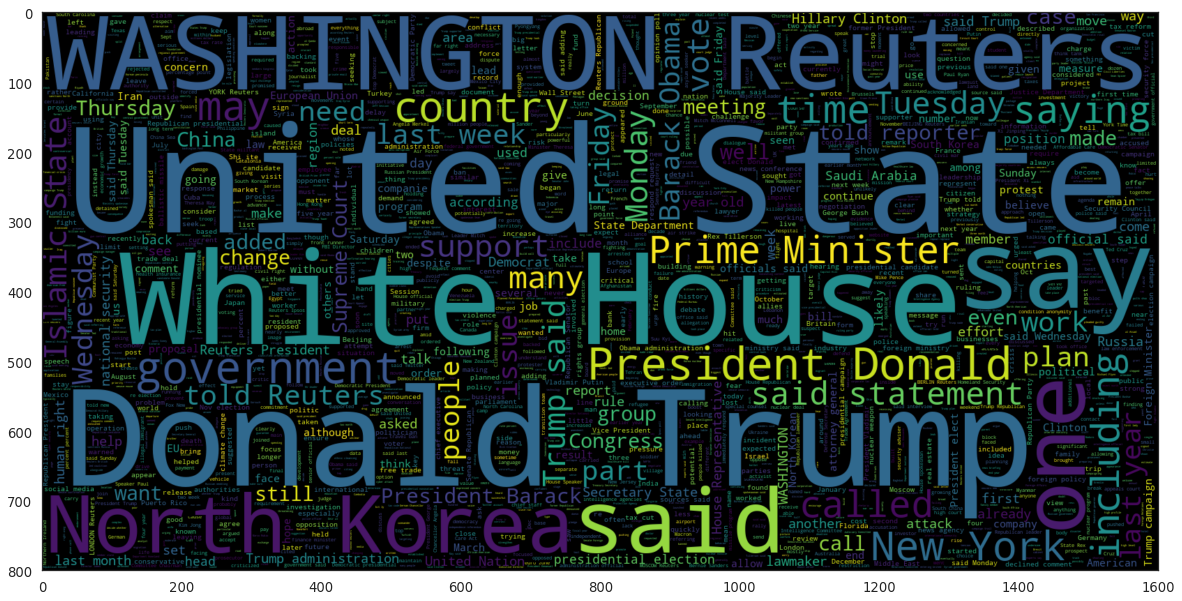

In [ ]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

**WORDCLOUD FOR FAKE TEXT (LABEL - 0)**

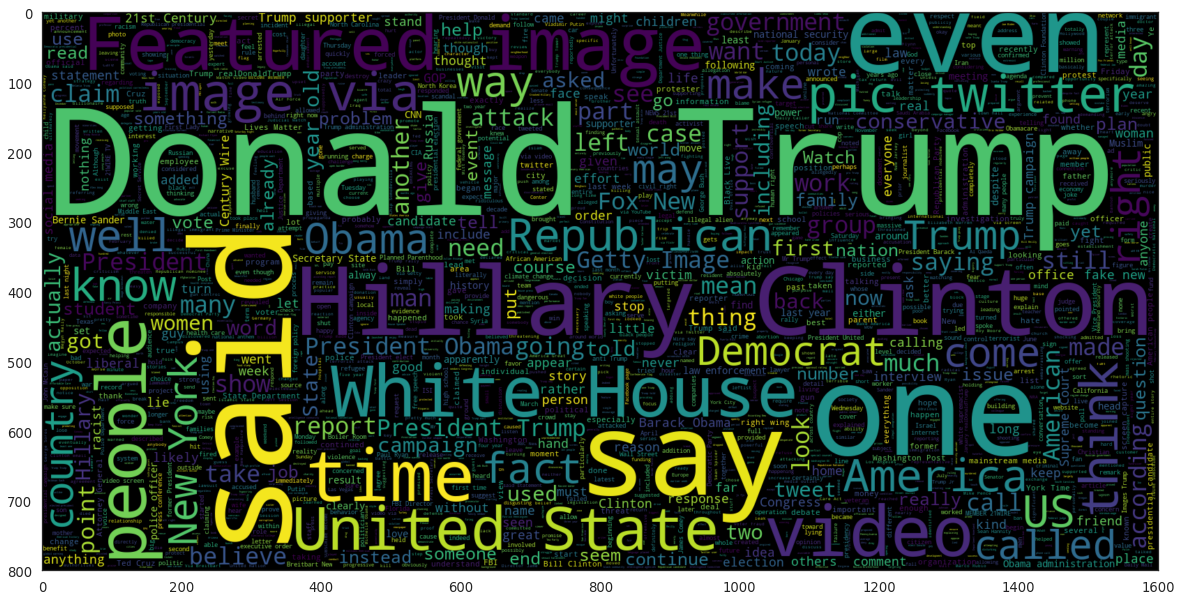

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

**Number of characters in texts**

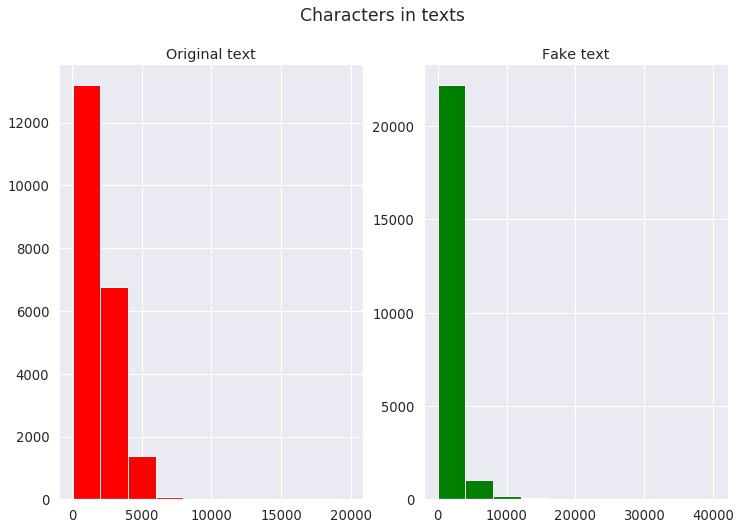

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

**The distribution of both seems to be a bit different. 2500 characters in text is the most common in original text category while around 5000 characters in text are most common in fake text category.**

**Number of words in each text**

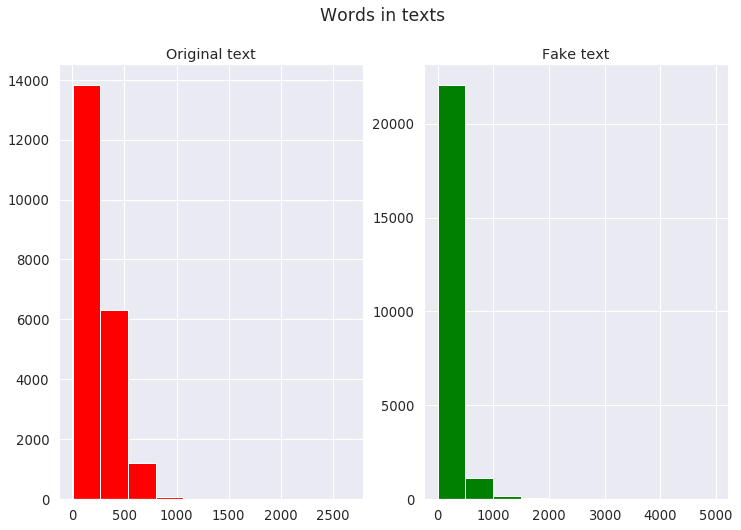

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

**Average word length in a text**

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Average word length in each text')

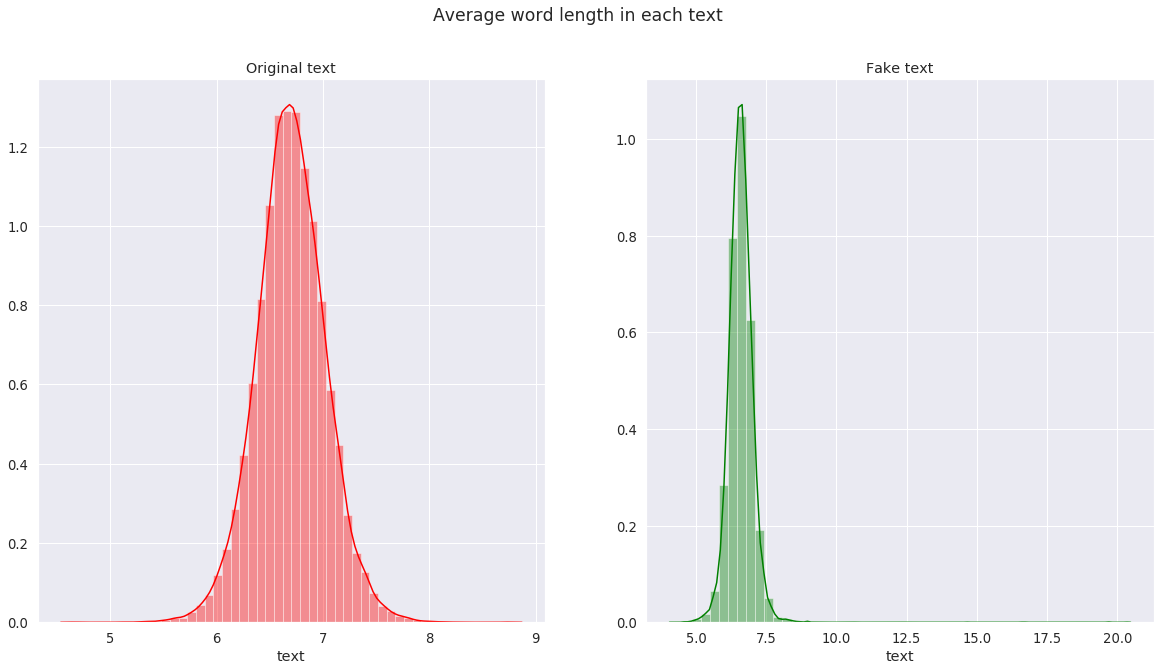

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

In [37]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df['Sentences'])
corpus[:5]

['Kellyanne', 'Conway', 'Meryl', 'Streep', 'Incited']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'US': 21384,
 'also': 21707,
 'one': 23599,
 'people': 24409,
 'percent': 41216,
 'said': 89222,
 'state': 31827,
 'tax': 26034,
 'would': 42543,
 'year': 21346}

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

**Unigram Analysis**

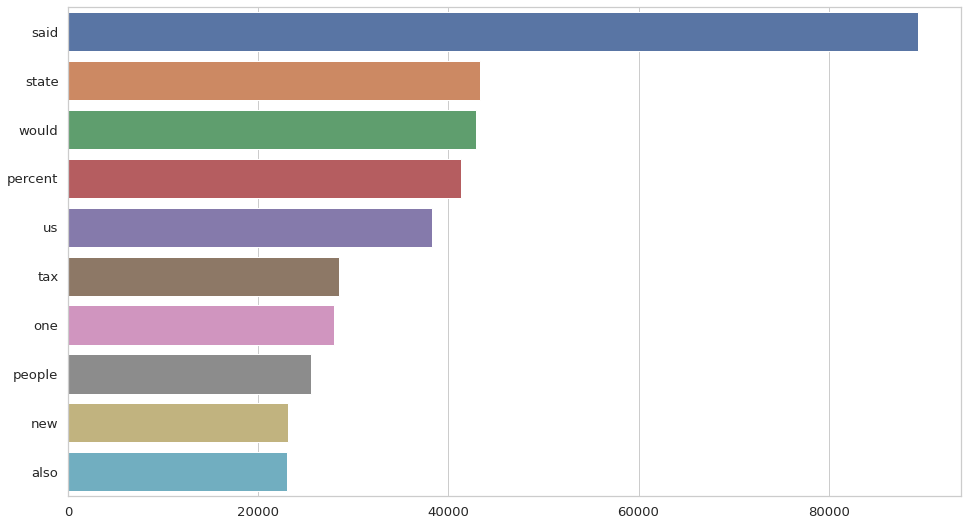

In [ ]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df['fullText_based_content'],10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

**Bigram Analysis**

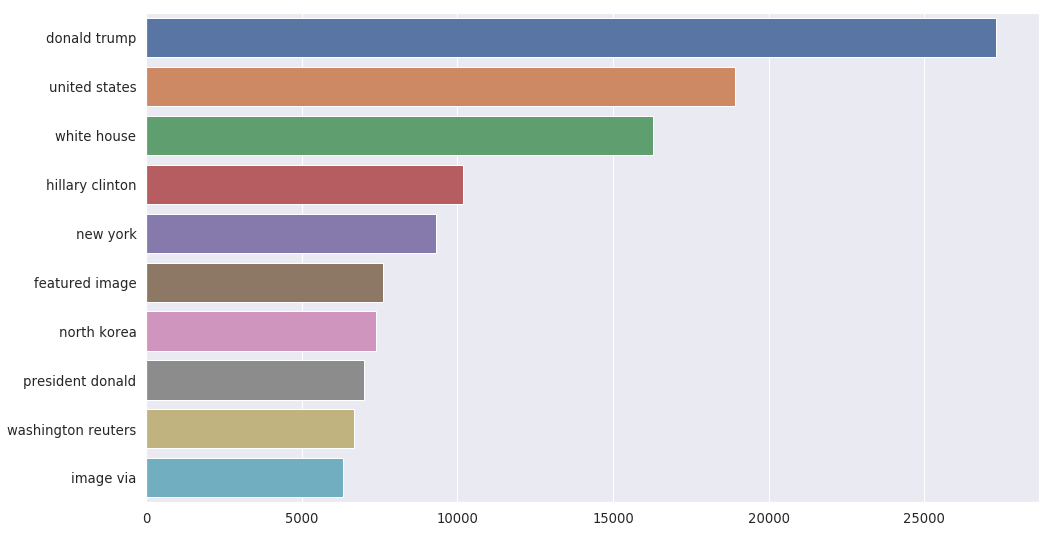

In [ ]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

**Trigram Analysis**

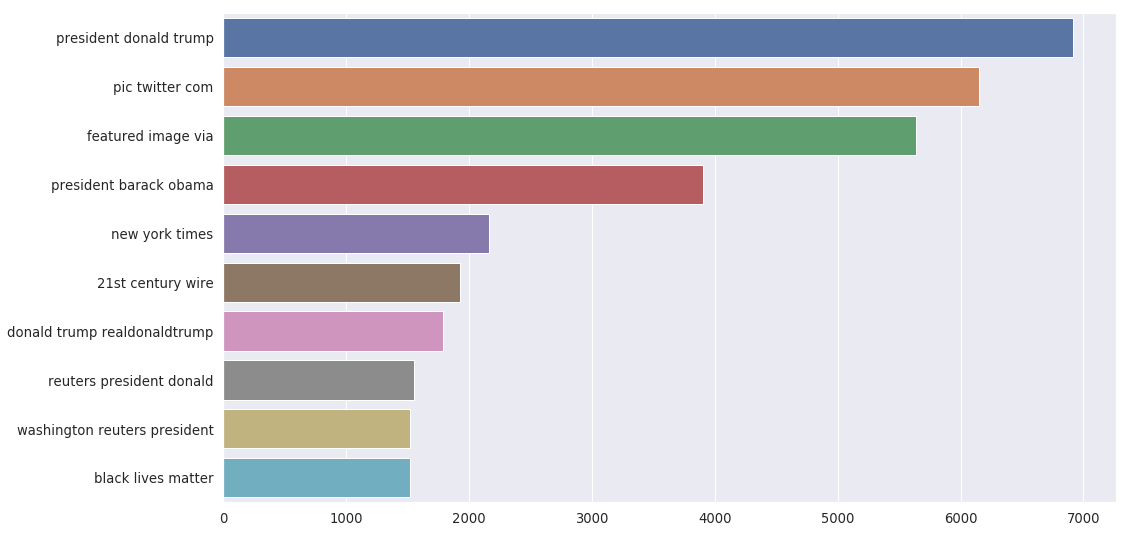

In [ ]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

**Splitting the data into 2 parts - training and testing data**

In [39]:
x_train,x_test,y_train,y_test = train_test_split(df['Sentences'],df['Label'],random_state = 0)

In [40]:
max_features = 10000
maxlen = 300

**Tokenizing Text -> Repsesenting each word by a number**

**Mapping of orginal word to number is preserved in word_index property of tokenizer**

**Tokenized applies basic processing like changing it to lower case, explicitely setting that as False**

**Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones**

In [41]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [42]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

# Introduction to GloVe
**GloVe method is built on an important idea,
You can derive semantic relationships between words from the co-occurrence matrix.
Given a corpus having V words, the co-occurrence matrix X will be a V x V matrix, where the i th row and j th column of X, X_ij denotes how many times word i has co-occurred with word j. An example co-occurrence matrix might look as follows.**
![image.png](attachment:image.png)

**The co-occurrence matrix for the sentence “the cat sat on the mat” with a window size of 1. As you probably noticed it is a symmetric matrix.
How do we get a metric that measures semantic similarity between words from this? For that, you will need three words at a time. Let me concretely lay down this statement.**

In [43]:
!pip install kaggle

In [45]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [46]:
!kaggle datasets download -d bertcarremans/glovetwitter27b100dtxt

 97% 386M/397M [00:05<00:00, 111MB/s] 
100% 397M/397M [00:06<00:00, 68.0MB/s]


In [47]:
from zipfile import ZipFile
file_name = 'glovetwitter27b100dtxt.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [48]:
EMBEDDING_FILE = '/content/glove.twitter.27B.100d.txt'

In [49]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [50]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


**Some Model Parameters**

In [51]:
batch_size = 256
epochs = 10
embed_size = 100

In [52]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

# TRAINING THE MODEL

In [53]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
132/132 [==============================] - 523s 4s/step - loss: 0.1431 - accuracy: 0.9477 - val_loss: 0.0789 - val_accuracy: 0.9713
Epoch 2/10
132/132 [==============================] - 520s 4s/step - loss: 0.0766 - accuracy: 0.9737 - val_loss: 0.0507 - val_accuracy: 0.9830
Epoch 3/10
132/132 [==============================] - 518s 4s/step - loss: 0.0433 - accuracy: 0.9850 - val_loss: 0.0470 - val_accuracy: 0.9847
Epoch 4/10
132/132 [==============================] - 520s 4s/step - loss: 0.0551 - accuracy: 0.9817 - val_loss: 0.0323 - val_accuracy: 0.9901
Epoch 5/10
132/132 [==============================] - 518s 4s/step - loss: 0.0348 - accuracy: 0.9878 - val_loss: 0.0539 - val_accuracy: 0.9866
Epoch 6/10
132/132 [==============================] - 519s 4s/step - loss: 0.0333 - accuracy: 0.9888 - val_loss: 0.0332 - val_accuracy: 0.9890

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 7/10
129/132 [============================>.] - ETA: 11s

# ANALYSIS AFTER TRAINING OF MODEL

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

383/383 [==============================] - 48s 124ms/step - loss: 0.3433 - accuracy: 0.8515
Accuracy of the model on Training Data is -  85.15280485153198 %
128/128 [==============================] - 16s 124ms/step - loss: 0.6249 - accuracy: 0.6767
Accuracy of the model on Testing Data is -  67.67156720161438 %


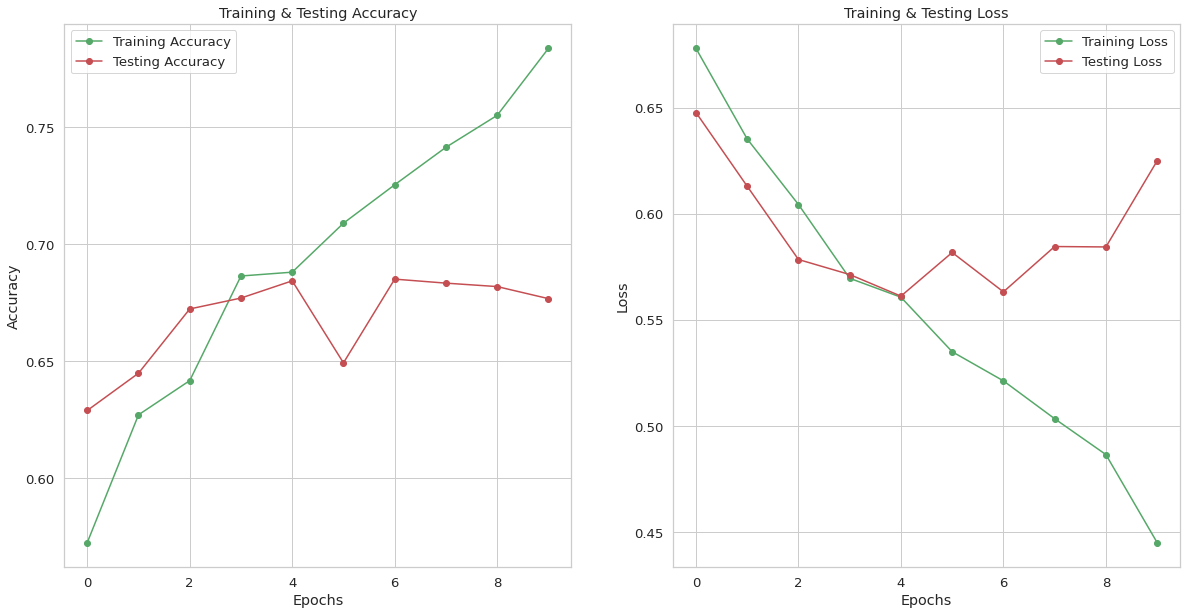

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred = model.predict_classes(X_test)
pred[:5]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0],
       [0],
       [0],
       [1],
       [1]], dtype=int32)

In [ ]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       0.65      0.70      0.67      1925
    Not Fake       0.71      0.66      0.68      2155

    accuracy                           0.68      4080
   macro avg       0.68      0.68      0.68      4080
weighted avg       0.68      0.68      0.68      4080



In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[1346,  579],
       [ 740, 1415]])

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(63.5, 0.5, 'Actual')

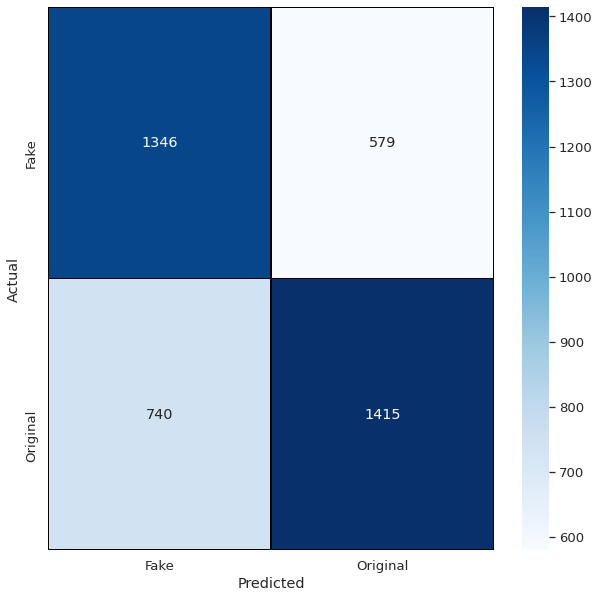

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

**PLS UPVOTE THIS NOTEBOOK IF YOU LIKE IT! THANKS FOR YOUR TIME !**

# CNN

In [ ]:
# build a 1D convnet with global maxpooling                                                                      

from keras import layers
from keras.models import Sequential

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),
        
        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 296, 128)          64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 1,080,769
Trainable params: 80,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
# train the model

history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
48/48 [==============================] - 19s 386ms/step - loss: 0.8004 - accuracy: 0.5286 - val_loss: 0.6422 - val_accuracy: 0.6120
Epoch 2/10
48/48 [==============================] - 18s 380ms/step - loss: 0.6484 - accuracy: 0.6073 - val_loss: 0.6261 - val_accuracy: 0.6294
Epoch 3/10
48/48 [==============================] - 18s 379ms/step - loss: 0.6091 - accuracy: 0.6560 - val_loss: 0.7538 - val_accuracy: 0.5605
Epoch 4/10
48/48 [==============================] - 18s 377ms/step - loss: 0.5834 - accuracy: 0.6804 - val_loss: 0.6737 - val_accuracy: 0.5998

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/10
48/48 [==============================] - 18s 380ms/step - loss: 0.5218 - accuracy: 0.7469 - val_loss: 0.6174 - val_accuracy: 0.6333
Epoch 6/10
48/48 [==============================] - 18s 377ms/step - loss: 0.4857 - accuracy: 0.7897 - val_loss: 0.6487 - val_accuracy: 0.6213
Epoch 7/10
48/48 [==============================] - 18s 379ms

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

383/383 [==============================] - 6s 16ms/step - loss: 0.3105 - accuracy: 0.9322
Accuracy of the model on Training Data is -  93.21784377098083 %
128/128 [==============================] - 2s 16ms/step - loss: 0.6281 - accuracy: 0.6475
Accuracy of the model on Testing Data is -  64.7549033164978 %


In [ ]:
from keras.layers import Dense,Embedding,LSTM,Dropout, Bidirectional,Input
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:

WREG = 0.0001 # embedding regularization
CREG = 0.00001 # CNN regularization
RREG = 0.00001 # LSTM regularization
DREG = 0.00001 # Fully connected regularization
WDROP_RATE = 0.50 # embedding dropout
CDROP_RATE = 0.33 # CNN dropout
RDROP_RATE = 0.25 # LSTM dropout
DDROP_RATE = 0.15 # fully connected dropout
CHIDDEN_SIZE = 32 # CNN size
RHIDDEN_SIZE = 64 # LSTM size 
DHIDDEN_SIZE = 128 # fully connected size
SEQ_LEN = maxlen
EPOCH = 10
BATCH_SIZE = 256

In [ ]:
modelv2 = Sequential()
modelv2.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
modelv2.add(Conv1D(filters = 128,kernel_regularizer=l2(CREG), 
              kernel_size=(3), 
              padding= "same", 
              strides=1,activation='relu'))
modelv2.add( MaxPooling1D(pool_size=2))
modelv2.add(Dropout(rate=CDROP_RATE))
modelv2.add(Bidirectional(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25)))
modelv2.add(Bidirectional(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.25)))
modelv2.add(Dense(units = 32 , activation = 'relu'))
modelv2.add(Dense(1, activation='sigmoid'))
modelv2.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10),
             ModelCheckpoint(filepath = 'best_model.h5', monitor= 'val_loss', save_best_only = True)]

In [ ]:
# train the model

history = modelv2.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
48/48 [==============================] - 286s 6s/step - loss: 0.6930 - accuracy: 0.5226 - val_loss: 0.6895 - val_accuracy: 0.5314
Epoch 2/10
48/48 [==============================] - 278s 6s/step - loss: 0.6841 - accuracy: 0.5547 - val_loss: 0.6626 - val_accuracy: 0.6010
Epoch 3/10
48/48 [==============================] - 278s 6s/step - loss: 0.6665 - accuracy: 0.5802 - val_loss: 0.6577 - val_accuracy: 0.5912
Epoch 4/10
48/48 [==============================] - 278s 6s/step - loss: 0.6341 - accuracy: 0.6261 - val_loss: 0.6205 - val_accuracy: 0.6228
Epoch 5/10
48/48 [==============================] - 279s 6s/step - loss: 0.6114 - accuracy: 0.6574 - val_loss: 0.5994 - val_accuracy: 0.6654
Epoch 6/10
48/48 [==============================] - 280s 6s/step - loss: 0.5944 - accuracy: 0.6687 - val_loss: 0.6150 - val_accuracy: 0.6353
Epoch 7/10
48/48 [==============================] - 280s 6s/step - loss: 0.5891 - accuracy: 0.6783 - val_loss: 0.6127 - val_accuracy: 0.6623

Epoch 00007:

In [ ]:
print("Accuracy of the model on Training Data is - " , modelv2.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , modelv2.evaluate(X_test,y_test)[1]*100 , "%")

383/383 [==============================] - 63s 164ms/step - loss: 0.5004 - accuracy: 0.7652
Accuracy of the model on Training Data is -  76.5157699584961 %
128/128 [==============================] - 21s 163ms/step - loss: 0.5957 - accuracy: 0.6806
Accuracy of the model on Testing Data is -  68.06372404098511 %


# CNN-LSTM

In [ ]:
modelv4 = Sequential()
modelv4.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
modelv4.add(Conv1D(filters = 128,kernel_regularizer=l2(CREG), 
              kernel_size=(3), 
              padding= "same", 
              strides=1,activation='relu'))
modelv4.add( MaxPooling1D(pool_size=2))
modelv4.add(Dropout(rate=CDROP_RATE))
modelv4.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
modelv4.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.25))
modelv4.add(Dense(units = 32 , activation = 'relu'))
modelv4.add(Dense(1, activation='sigmoid'))
modelv4.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# train the model

history = modelv4.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
48/48 [==============================] - 132s 3s/step - loss: 0.7153 - accuracy: 0.5094 - val_loss: 0.6917 - val_accuracy: 0.5873
Epoch 2/10
48/48 [==============================] - 123s 3s/step - loss: 0.6872 - accuracy: 0.5527 - val_loss: 0.6507 - val_accuracy: 0.6194
Epoch 3/10
48/48 [==============================] - 122s 3s/step - loss: 0.6377 - accuracy: 0.6185 - val_loss: 0.6120 - val_accuracy: 0.6412
Epoch 4/10
48/48 [==============================] - 122s 3s/step - loss: 0.6196 - accuracy: 0.6348 - val_loss: 0.6041 - val_accuracy: 0.6525
Epoch 5/10
48/48 [==============================] - 122s 3s/step - loss: 0.5988 - accuracy: 0.6619 - val_loss: 0.5871 - val_accuracy: 0.6775
Epoch 6/10
48/48 [==============================] - 123s 3s/step - loss: 0.5837 - accuracy: 0.6846 - val_loss: 0.5881 - val_accuracy: 0.6691
Epoch 7/10
48/48 [==============================] - 122s 3s/step - loss: 0.5698 - accuracy: 0.6958 - val_loss: 0.5880 - val_accuracy: 0.6767

Epoch 00007:

In [ ]:
print("Accuracy of the model on Training Data is - " , modelv4.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , modelv4.evaluate(X_test,y_test)[1]*100 , "%")

383/383 [==============================] - 31s 81ms/step - loss: 0.4858 - accuracy: 0.7697
Accuracy of the model on Training Data is -  76.97336077690125 %
128/128 [==============================] - 10s 80ms/step - loss: 0.6022 - accuracy: 0.6814
Accuracy of the model on Testing Data is -  68.13725233078003 %


# Bi-LSTM

In [ ]:
#giving vector features

embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length = sent_length))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.4))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 300, 100)          1000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 100)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 201       
Total params: 1,161,001
Trainable params: 161,001
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
# train the model

history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
48/48 [==============================] - 111s 2s/step - loss: 0.6820 - accuracy: 0.5538 - val_loss: 0.6427 - val_accuracy: 0.6319
Epoch 2/10
48/48 [==============================] - 107s 2s/step - loss: 0.6394 - accuracy: 0.6224 - val_loss: 0.6258 - val_accuracy: 0.6328
Epoch 3/10
48/48 [==============================] - 105s 2s/step - loss: 0.6322 - accuracy: 0.6247 - val_loss: 0.6242 - val_accuracy: 0.6248
Epoch 4/10
48/48 [==============================] - 106s 2s/step - loss: 0.6237 - accuracy: 0.6337 - val_loss: 0.6188 - val_accuracy: 0.6331
Epoch 5/10
48/48 [==============================] - 105s 2s/step - loss: 0.6145 - accuracy: 0.6490 - val_loss: 0.6137 - val_accuracy: 0.6331
Epoch 6/10
48/48 [==============================] - 105s 2s/step - loss: 0.6122 - accuracy: 0.6476 - val_loss: 0.6090 - val_accuracy: 0.6431
Epoch 7/10
48/48 [==============================] - 105s 2s/step - loss: 0.6000 - accuracy: 0.6603 - val_loss: 0.6054 - val_accuracy: 0.6417
Epoch 8/10
48

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

383/383 [==============================] - 32s 84ms/step - loss: 0.5650 - accuracy: 0.6913
Accuracy of the model on Training Data is -  69.12894248962402 %
128/128 [==============================] - 11s 83ms/step - loss: 0.6045 - accuracy: 0.6583
Accuracy of the model on Testing Data is -  65.83333611488342 %


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Embedding, GRU, LSTM, RNN, SpatialDropout1D

# GRU

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(GRU(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(GRU(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# train the model

history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
48/48 [==============================] - 164s 3s/step - loss: 0.6878 - accuracy: 0.5561 - val_loss: 0.5987 - val_accuracy: 0.6618
Epoch 2/10
48/48 [==============================] - 158s 3s/step - loss: 0.5920 - accuracy: 0.6657 - val_loss: 0.5571 - val_accuracy: 0.6877
Epoch 3/10
48/48 [==============================] - 158s 3s/step - loss: 0.5702 - accuracy: 0.6757 - val_loss: 0.5467 - val_accuracy: 0.6958
Epoch 4/10
48/48 [==============================] - 158s 3s/step - loss: 0.5415 - accuracy: 0.6989 - val_loss: 0.5532 - val_accuracy: 0.7042
Epoch 5/10
48/48 [==============================] - 158s 3s/step - loss: 0.5310 - accuracy: 0.7134 - val_loss: 0.5570 - val_accuracy: 0.6900
Epoch 6/10
48/48 [==============================] - 159s 3s/step - loss: 0.5095 - accuracy: 0.7386 - val_loss: 0.5518 - val_accuracy: 0.6848

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 7/10
48/48 [==============================] - 158s 3s/step - loss: 0

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

383/383 [==============================] - 41s 106ms/step - loss: 0.3366 - accuracy: 0.8480
Accuracy of the model on Training Data is -  84.80143547058105 %
128/128 [==============================] - 14s 106ms/step - loss: 0.6170 - accuracy: 0.6939
Accuracy of the model on Testing Data is -  69.38725709915161 %


In [ ]:
pred = model.predict_classes(X_test)
pred[:5]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0],
       [0],
       [1],
       [1],
       [1]], dtype=int32)

In [ ]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       0.67      0.70      0.68      1925
    Not Fake       0.72      0.69      0.71      2155

    accuracy                           0.69      4080
   macro avg       0.69      0.69      0.69      4080
weighted avg       0.69      0.69      0.69      4080



In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[1338,  587],
       [ 662, 1493]])

In [ ]:
modelv4 = Sequential()
modelv4.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
modelv4.add(Conv1D(filters = 128,kernel_regularizer=l2(CREG), 
              kernel_size=(3), 
              padding= "same", 
              strides=1,activation='relu'))
modelv4.add( MaxPooling1D(pool_size=2))
modelv4.add(Dropout(rate=CDROP_RATE))
modelv4.add(GRU(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
modelv4.add(GRU(units=64 , recurrent_dropout = 0.1 , dropout = 0.25))
modelv4.add(Dense(units = 32 , activation = 'relu'))
modelv4.add(Dense(1, activation='sigmoid'))
modelv4.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# train the model
history = modelv4.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
48/48 [==============================] - 115s 2s/step - loss: 0.7312 - accuracy: 0.5061 - val_loss: 0.6898 - val_accuracy: 0.5370
Epoch 2/10
48/48 [==============================] - 105s 2s/step - loss: 0.6908 - accuracy: 0.5246 - val_loss: 0.6703 - val_accuracy: 0.6066
Epoch 3/10
48/48 [==============================] - 105s 2s/step - loss: 0.6467 - accuracy: 0.6118 - val_loss: 0.6046 - val_accuracy: 0.6480
Epoch 4/10
48/48 [==============================] - 105s 2s/step - loss: 0.6124 - accuracy: 0.6485 - val_loss: 0.5897 - val_accuracy: 0.6833
Epoch 5/10
48/48 [==============================] - 105s 2s/step - loss: 0.5881 - accuracy: 0.6792 - val_loss: 0.5894 - val_accuracy: 0.6716
Epoch 6/10
48/48 [==============================] - 105s 2s/step - loss: 0.5832 - accuracy: 0.6779 - val_loss: 0.5897 - val_accuracy: 0.6775

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 7/10
48/48 [==============================] - 105s 2s/step - loss: 0

In [ ]:
print("Accuracy of the model on Training Data is - " , modelv4.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , modelv4.evaluate(X_test,y_test)[1]*100 , "%")

383/383 [==============================] - 27s 71ms/step - loss: 0.4922 - accuracy: 0.7713
Accuracy of the model on Training Data is -  77.1286129951477 %
128/128 [==============================] - 9s 72ms/step - loss: 0.5898 - accuracy: 0.6826
Accuracy of the model on Testing Data is -  68.25980544090271 %
